In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

test['loss'] = np.nan
joined = pd.concat([train, test])

In [3]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

In [4]:
cat_feature = [n for n in joined.columns if n.startswith('cat')]    
cont_feature = [n for n in joined.columns if n.startswith('cont')] 

for column in cat_feature:
    joined[column] = pd.factorize(joined[column].values, sort=True)[0]
    
train = joined[joined['loss'].notnull()]
test = joined[joined['loss'].isnull()]

shift = 200
y = np.log(train['loss'] + shift)
ids = test['id']
X = train.drop(['loss', 'id'], 1)
X_test = test.drop(['loss', 'id'], 1)

In [9]:
print(y.skew())
print(y.describe())

0.301411340599
count    188318.000000
mean          7.799837
std           0.731553
min           5.301662
25%           7.247408
50%           7.747411
75%           8.309934
max          11.705298
Name: loss, dtype: float64


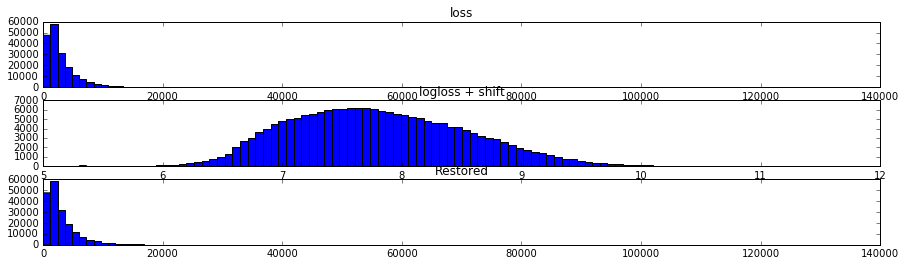

In [15]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(train['loss'],100)
plt.title('loss');
plt.subplot(3,1,2)
plt.hist(y,100)
plt.title('logloss + shift');
plt.subplot(3,1,3)
plt.hist(np.exp(y)-shift,100)
plt.title('Restored');

In [10]:
X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [24]:
joined['cat109'].head()

0    46
1    34
2     2
3    34
4    67
Name: cat109, dtype: int64

In [25]:
X.get_values()

array([[ 0.      ,  1.      ,  0.      , ...,  0.594646,  0.822493,
         0.714843],
       [ 0.      ,  1.      ,  0.      , ...,  0.366307,  0.611431,
         0.304496],
       [ 0.      ,  1.      ,  0.      , ...,  0.373424,  0.195709,
         0.774425],
       ..., 
       [ 0.      ,  1.      ,  0.      , ...,  0.443374,  0.339244,
         0.503888],
       [ 0.      ,  1.      ,  0.      , ...,  0.852865,  0.654753,
         0.721707],
       [ 1.      ,  0.      ,  0.      , ...,  0.946432,  0.810511,
         0.72146 ]])

In [ ]:

#X = X.sample(frac=0.1)
#y = y .iloc[X.index.values]

n_folds  = 5
kf = KFold(X.shape[0], n_folds=n_folds)
prediction = np.zeros(ids.shape)

final_fold_prediction= []
final_fold_real = []

partial_evalutaion = open('temp_scores.txt','w')
for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i + 1))
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]    

    RANDOM_STATE = 2016
    params = {
        'min_child_weight': 1,
        'eta': 0.001,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'silent': 1,
        'verbose_eval': True,
        'seed': RANDOM_STATE
    }

    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtrain_2 = xgb.DMatrix(X_val, label=y_val)

    xgtest = xgb.DMatrix(X_test)   


    watchlist = [(xgtrain, 'train'), (xgtrain_2, 'eval')]



    model = xgb.train(params, xgtrain, 100000, watchlist, obj=logregobj, feval=evalerror, early_stopping_rounds=300)        
    prediction += np.exp(model.predict(xgtest)) - shift

    X_val = xgb.DMatrix(X_val) 
    temp_serises = pd.Series(np.exp(model.predict(X_val))-shift)
    final_fold_prediction.append( temp_serises )
    temp_serises = np.exp(y_val) -shift
    final_fold_real.append(temp_serises )

    temp_cv_score = mean_absolute_error(np.exp(model.predict(X_val))-shift, np.exp(y_val) -shift)

    partial_evalutaion.write('fold '+str(i)+' '+str(temp_cv_score)+'\n')
    partial_evalutaion.flush()



prediction = prediction/n_folds
submission = pd.DataFrame()
submission['id'] = ids    
submission['loss'] = prediction

submission.to_csv('sub_v_5_long2.csv', index=False)

final_fold_prediction = pd.concat(final_fold_prediction,ignore_index=True)
final_fold_real = pd.concat(final_fold_real,ignore_index=True)

cv_score = mean_absolute_error(final_fold_prediction, final_fold_real)
print cv_score


 Fold 1
[0]	train-mae:3236.86	eval-mae:3230.73
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 300 rounds.
[1]	train-mae:3236.8	eval-mae:3230.68
[2]	train-mae:3236.74	eval-mae:3230.62
[3]	train-mae:3236.68	eval-mae:3230.56
[4]	train-mae:3236.62	eval-mae:3230.49
[5]	train-mae:3236.55	eval-mae:3230.43
[6]	train-mae:3236.49	eval-mae:3230.37
[7]	train-mae:3236.42	eval-mae:3230.3
[8]	train-mae:3236.35	eval-mae:3230.23
[9]	train-mae:3236.28	eval-mae:3230.16
[10]	train-mae:3236.21	eval-mae:3230.09
[11]	train-mae:3236.14	eval-mae:3230.02
[12]	train-mae:3236.06	eval-mae:3229.94
[13]	train-mae:3235.99	eval-mae:3229.86
[14]	train-mae:3235.91	eval-mae:3229.79
[15]	train-mae:3235.83	eval-mae:3229.71
[16]	train-mae:3235.75	eval-mae:3229.62
[17]	train-mae:3235.66	eval-mae:3229.54
[18]	train-mae:3235.58	eval-mae:3229.45
[19]	train-mae:3235.49	eval-mae:3229.37
[20]	train-mae:3235.4	eval-mae:3229.28
[21]	train-mae:3235.31

# save files for submission

In [44]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [45]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [56]:
from sklearn.externals import joblib
joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_test, shift]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

['../output/models-raw-features-rescale-loss-shift.pkl']

In [ ]:
testList
